# Average Annual Daily Traffic (Current)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/trans-aadt-traffic-segments

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# import psycopg2
# from psycopg2 import sql, extras

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd

# Get CWD

cwd = os.getcwd() # This is a global variable for where the notebook is (must change if running in arcpro)

In [2]:
### Definitions

def extract_zip_from_url(url=None, path=None):
    '''Extract a zipfile from the internet
    then unpack it in to it's own folder 
    within the working directory.
    Takes a single url (string).'''

    if not os.path.exists(path):
        os.mkdir(path)
    # Unload zip into the new folder
    response = urllib.request.urlopen(url) # Get a response
    zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
    zip_folder.extractall(path=path) # Extract files
    zip_folder.close() # Close zip object

In [5]:
### Download
    
## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dot/trans_aadt_traffic_segments/shp_trans_aadt_traffic_segments.zip'

# Create folder name for file
folder_name = url.split('/')[-1][:-4]
# Make folder for files
savepath = os.path.join(cwd, '..','..','Data', folder_name)

extract_zip_from_url(url, savepath)

In [6]:
# Load Data

# AADT

filename = 'Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp'
path = os.path.join(savepath, filename)

aadt_mn = gpd.read_file(path)

# Minneapolis Boundary

filename = 'mpls_boundary.geojson'
path = os.path.join('..', '..', 'Data', filename)

mpls_boundary = gpd.read_file(path)

<Axes: >

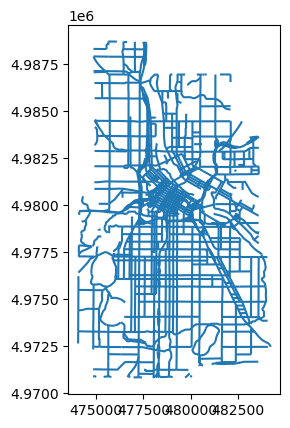

In [7]:
# Clip to extent
    
clipped_aadt = gpd.clip(aadt_mn, mpls_boundary)

clipped_aadt.plot()

In [8]:
clipped_aadt.head()

,SEQUENCE_N,FROM_DATE,TO_DATE,ROUTE_LABE,STREET_NAM,LOCATION_D,VEHICLE_CL,DAILY_FACT,SEASONAL_F,AXLE_FACTO,CURRENT_YE,CURRENT_VO,AADT_COMME,DATA_TYPE,SHAPE_Leng,geometry
26553,42758,1994-01-01,4000-01-01,CSAH 52,Nicollet Ave S,S OF TH62,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Urban Minor Arterial,2021,9937.0,"11 Est Henn Co (10 Cnt), 07 RCH",A,1006.889719,"LINESTRING (478040.611 4970839.766, 478040.844..."
22854,37113,1996-01-01,4000-01-01,MSAS 363,Lyndale Ave S,S OF TH62,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Urban Minor Arterial,2022,12405.0,"09 Est Hist, Const",A,677.846757,"LINESTRING (477238.878 4970836.773, 477238.767..."
26554,42759,1994-01-01,4000-01-01,CSAH 35,Portland Ave S,S OF TH62,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,4-Urban Minor Arterial,2021,14324.0,"21 See Hist, 11 Est Henn Co (10 Cnt), 07 RCL",A,868.323377,"LINESTRING (478854.496 4970845.160, 478854.469..."
36352,73215,2020-01-01,4000-01-01,CON 3358,NaN,WB MN 62 TO NB I-35W,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,1-Urban Interstate,2022,21548.0,"22 Lim Hist, 21 Lim Hist, 20 COVID",A,71.026293,"LINESTRING (478391.566 4970874.395, 478406.918..."
36355,73218,2020-01-01,4000-01-01,CON 5287,NaN,WB MN 62 TO CSAH 35,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,2-Urban Principal Arterial OFE,2022,2548.0,20 COVID,A,200.745479,"LINESTRING (479051.268 4970854.045, 479049.505..."


In [61]:
# correct column names

cols_old = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM',
                'DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO',
                'CURRENT_YE','CURRENT_VO', 'STREET_NAM']

cols_new = ['SEQUENCE_NUMBER','ROUTE_LABEL','STREET_NAME',
                      'DAILY_FACTOR', 'SEASONAL_FACTOR', 'AXLE_FACTOR',
                      'CURRENT_YEAR','CURRENT_VOLUME', 'STREET_NAME']

cols_dict = dict(zip(cols_old, cols_new))
aadt_for_db = clipped_aadt.rename(columns= cols_dict)

aadt_for_db.columns

Index(['SEQUENCE_NUMBER', 'FROM_DATE', 'TO_DATE', 'ROUTE_LABEL', 'STREET_NAME',
       'LOCATION_D', 'VEHICLE_CL', 'DAILY_FACTOR', 'SEASONAL_FACTOR',
       'AXLE_FACTOR', 'CURRENT_YEAR', 'CURRENT_VOLUME', 'AADT_COMME',
       'DATA_TYPE', 'SHAPE_Leng', 'geometry'],
      dtype='object')

In [137]:
# Get the list of important street names

# Narrow by streets with names that have high volume

# Remove Nans in aadt_for_db

no_nan_df = aadt_for_db.dropna()

# Dissolve by route_label

grouped_df = no_nan_df.dissolve(by='ROUTE_LABEL', aggfunc={'STREET_NAME':'unique',
                                                            'CURRENT_VOLUME':'mean'}).reset_index()
# Select high volume intersections with names
select_df = grouped_df[(grouped_df.CURRENT_VOLUME > 1000)]

important_street_names = select_df.STREET_NAME.explode().unique()

In [138]:
# Get all the directions of lines with name in above list

# Select the streets from above and that have linestrings (not multilinestrings) in their geometry

focus_df = aadt_for_db[(aadt_for_db.STREET_NAME.isin(important_street_names))&
                        (aadt_for_db.geometry.type != 'MultiLineString')].copy() 

# Get the line trend of each

def get_linetrend(geom):
    '''This looks at the first and last points in a UTM geometry linestring 
    and says if it trends more North South (NS) or East West (EW)
    '''
    
    coords = list(geom.coords)

    first_coord = coords[0]
    last_coord = coords[-1]

    ns_trend = abs(first_coord[1] - last_coord[1])

    ew_trend = abs(first_coord[0] - last_coord[0])

    if ns_trend > ew_trend:
        result = 'NS'
    else:
        result = 'EW'

    return result

focus_df['linetrend'] = focus_df.geometry.apply(lambda x: get_linetrend(x))

In [139]:
# Get all intersections of roads

# Cross join - https://gis.stackexchange.com/questions/439723/implementing-polygon-self-intersection-in-python

focus_df['id'] = np.arange(focus_df.shape[0]) #Create an id column

cross = pd.merge(left=focus_df, right=focus_df, how='cross') #Cross join the dataframe to itself

cross = cross.loc[cross['id_x'] < cross['id_y']] #Remove self joins

cross = cross.loc[cross.geometry_x.intersects(cross.geometry_y)] #Select only polygons intersecting

cross['inter'] = cross.geometry_x.intersection(cross.geometry_y) #Intersect them

cross = cross.set_geometry('inter') #The error was here. I thought set_geometry was inplace, but it is returning the dataframe

cross = cross[[column for column in cross.columns if 'geom' not in column]] #Drop old geometries

In [142]:
# Now to find the NS and EW cross streets

cross['NS_cross_street'] = None
cross['EW_cross_street'] = None

for i, row in cross.iterrows():

    # Get NS cross street

    if row.linetrend_x == 'NS':
        cross.loc[i, 'NS_cross_street'] = row.STREET_NAME_x
    elif row.linetrend_y == 'NS': 
        cross.loc[i, 'NS_cross_street'] = row.STREET_NAME_y

    # Get EW cross street

    if row.linetrend_x == 'EW':
        cross.loc[i, 'EW_cross_street'] = row.STREET_NAME_x
    elif row.linetrend_y == 'EW': 
        cross.loc[i, 'EW_cross_street'] = row.STREET_NAME_y

# The final dataframe?

intersections_df = cross[['NS_cross_street', 'EW_cross_street', 'inter']].dropna().copy().reset_index(drop=True)

intersections_df

,NS_cross_street,EW_cross_street,inter
0,Nicollet Ave S,W 61st St,POINT (478042.278 4971026.506)
1,Lyndale Ave S,W 61st St,POINT (477234.219 4971031.999)
2,Lyndale Ave S,W 61st St,POINT (477234.219 4971031.999)
3,Nicollet Ave S,W 61st St,POINT (478042.278 4971026.506)
4,Portland Ave S,E 60th St,POINT (478860.281 4971245.500)
...,...,...,...
1303,46th Ave S,E 38th St,POINT (483613.351 4975675.471)
1304,46th Ave S,E 38th St,POINT (483613.351 4975675.471)
1305,W River Pkwy,E 38th St,POINT (483980.374 4975676.203)
1306,46th Ave S,E Lake St,POINT (483620.876 4977236.500)


<Axes: >

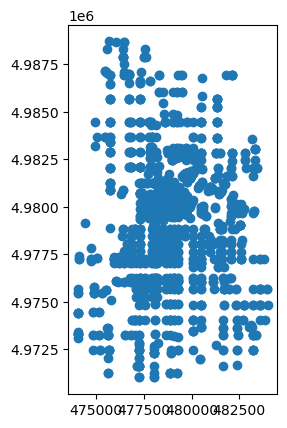

In [143]:
# Looks like good coverage

intersections_df.plot()

In [133]:
# Let's Save that

intersections_df.to_file(os.path.join('..', '..', 'Data', 'road_intersections.geojson')

array(['Nicollet Ave S', 'Lyndale Ave S', 'Portland Ave S',
       'Chicago Ave S', 'Penn Ave S', 'Luverne Ave', '28th Ave S',
       '34th Ave S', '42nd Ave S', 'W Lake Nokomis Pkwy',
       'Bloomington Ave S', 'Cedar Ave S', 'France Ave S', 'Market Plz',
       'Dean Blvd', 'W Lake Calhoun Pkwy', 'E Lake Calhoun Pkwy',
       'Cedar Lake Pkwy', 'Xerxes Ave S', 'Upton Ave S',
       'W Minnehaha Pkwy', 'Dupont Ave S', 'E Lake Harriet Pkwy',
       '4th Ave S', 'Park Ave S', 'Bryant Ave S', 'Grand Ave S',
       'W 39th St', '1st Ave S', 'Blaisdell Ave S', 'Kings Hwy',
       'William Berry Pkwy', 'Hennepin Ave S', 'Emerson Ave S',
       'Irving Ave S', 'E Lake Nokomis Pkwy', 'Hiawatha Ave',
       'Minnehaha Ave', 'W River Pkwy', '46th Ave S', '23rd Ave S',
       '31st Ave S', '36th Ave S', '27th Ave S', '26th Ave S',
       '2nd Ave S', '5th Ave S', 'Stevens Ave S', 'La Salle Ave S',
       '3rd Ave S', 'E River Pkwy', '11th Ave S', '27th Ave SE',
       'E Franklin Ave', '20th Av

In [21]:
aadt_for_db.dissolve(by='ROUTE_LABEL').reset_index()

,ROUTE_LABEL,geometry,SEQUENCE_NUMBER,FROM_DATE,TO_DATE,STREET_NAME,LOCATION_D,VEHICLE_CL,DAILY_FACTOR,SEASONAL_FACTOR,AXLE_FACTOR,CURRENT_YEAR,CURRENT_VOLUME,AADT_COMME,DATA_TYPE,SHAPE_Leng
0,CON 1018,"LINESTRING (477131.469 4980127.510, 477215.546...",73055,2020-01-01,4000-01-01,None,EB I-394 TO NB I-94,0,9 - High WkDay/Commuter,9 - High WkDay/Commuter,1-Urban Interstate,2022,5948.0,20 COVID,A,505.675423
1,CON 1019,"LINESTRING (477862.856 4980536.099, 477891.535...",74023,2020-01-01,4000-01-01,None,I-394 TO MSAS 208,0,9 - High WkDay/Commuter,9 - High WkDay/Commuter,1-Urban Interstate,2022,3564.0,"21 Lim Hist, 20 COVID",A,495.706515
2,CON 1023,"LINESTRING (482543.773 4983090.625, 482475.251...",73734,2020-01-01,4000-01-01,None,WB I-35W TO CSAH 27,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,1-Urban Interstate,2022,7387.0,20 COVID,A,437.703829
3,CON 1034,"LINESTRING (477662.907 4982188.600, 477630.514...",73052,2020-01-01,4000-01-01,None,M 2027 TO UNU 52,0,9 - High WkDay/Commuter,9 - High WkDay/Commuter,2-Urban Principal Arterial OFE,2022,6691.0,20 COVID,A,517.922032
4,CON 1098,"LINESTRING (479923.643 4980011.328, 479963.844...",73696,2020-01-01,4000-01-01,None,NB I-35W TO MSAS 340,0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,1-Urban Interstate,2021,2421.0,20 COVID,A,436.678249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,MSAS 452,"LINESTRING (478013.063 4981416.000, 478103.875...",67230,2006-01-01,4000-01-01,7th Ave N,S OF 3rd ST N,0,9 - High WkDay/Commuter,9 - High WkDay/Commuter,7-Urban Local,2008,1000.0,"12 No AADT, 08-07 Est",A,259.814040
585,MSAS 453,"LINESTRING (474064.932 4977257.700, 474065.132...",61988,1998-01-01,4000-01-01,France Ave S,N of CSAH25 (W Lake St),0,9 - High WkDay/Commuter,9 - High WkDay/Commuter,5-Urban Major Collector,2012,5200.0,"14 Move Loc, 12 Est Surr (11 Cnt), 08 Est Surr...",A,164.513467
586,MSAS 454,"LINESTRING (478274.500 4986049.500, 478502.344...",68217,2009-01-01,4000-01-01,Saint Anthony Pkwy,E OF CSAH23 (MARSHALL ST),0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,6-Urban Minor Collector,2021,3354.0,"17 Avg Hist, 12 Est Hist (09 Cnt), 10 New Loc",A,1233.189091
587,PVT 806,"LINESTRING (481801.844 4982430.000, 481803.282...",76170,2022-01-01,4000-01-01,Cleveland St NE,N of MSAS 2365 (Kennedy St NE),0,11 - Sim WkDay/WkEnd,11 - Sim WkDay/WkEnd,7-Urban Local,2022,169.0,None,A,206.004019


In [ ]:
# correct column names

cols_for_arc = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM',
                'DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO',
                'CURRENT_YE','CURRENT_VO', 'SHAPE@WKT']

cols_for_dataframe = ['SEQUENCE_NUMBER','ROUTE_LABEL','STREET_NAME',
                      'DAILY_FACTOR', 'SEASONAL_FACTOR', 'AXLE_FACTOR',
                      'CURRENT_YEAR','CURRENT_VOLUME', 'geometry']

In [9]:
# Save

clipped_aadt.to_file(os.path.join('..', '..', 'Data', 'mpls_aadt.geojson'))

In [48]:
# Upload to Database (NOT DONE, CHANGE THIS!)

# Get credentials

cred_pth = os.path.join(os.getcwd(), '..', '..', 'database', 'db_credentials.txt')

with open(cred_pth, 'r') as f:
    
    creds = f.readlines()[0].rstrip('\n').split(', ')
    
# Connect to PostGIS Database

pg_connection_dict = dict(zip(['dbname', 'user', 'password', 'port', 'host'], creds))

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

cols_for_arc = ['SEQUENCE_N','ROUTE_LABE','STREET_NAM',
                'DAILY_FACT', 'SEASONAL_F', 'AXLE_FACTO',
                'CURRENT_YE','CURRENT_VO', 'SHAPE@WKT']

cols_for_dataframe = ['SEQUENCE_NUMBER','ROUTE_LABEL','STREET_NAME',
                      'DAILY_FACTOR', 'SEASONAL_FACTOR', 'AXLE_FACTOR',
                      'CURRENT_YEAR','CURRENT_VOLUME', 'geometry']

cols_for_dataframe = [col.lower() for col in cols_for_dataframe] # Must lowercase our columns...


cursor = arcpy.da.SearchCursor(clipped_aadt, cols_for_arc)

for row in cursor:
    
    # This is really a great way to insert a lot of data
    
    q1 = sql.SQL('INSERT INTO MNDOT_Current_AADT_Segments ({}) VALUES ({},{});').format(
     sql.SQL(', ').join(map(sql.Identifier, cols_for_dataframe)),
     sql.SQL(', ').join(sql.Placeholder() * (len(cols_for_dataframe)-1)),
     sql.SQL('ST_Transform(ST_SetSRID(ST_GeomFromText(%s), 26915),4326)::geometry'))
#     print(q1.as_string(conn))
#     break

    cur.execute(q1.as_string(conn),
        (row)
        )
    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()